In [1]:
import torch
import yaml
import time
import numpy as np
from pathlib import Path
from torch.utils.data import DataLoader
from torch_ema import ExponentialMovingAverage

from models.state_mlp import StateMLP
from data.lasa_data import StatePyLASADataset, wrap
from utils.plotting import plot_flow_on_sphere, plot_3d_points
from utils.manifold_utils import *

from flow_matching.utils.manifolds import Manifold, Sphere
from flow_matching.path import GeodesicProbPath
from flow_matching.path.scheduler import CondOTScheduler

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from soft_dtw import SoftDTW
import os
from tqdm import tqdm
from typing import Dict, Any

Using LASA DataSet from /home/stanislav/anaconda3/envs/ml_env/lib/python3.12/site-packages/pyLasaDataset/resources/LASAHandwritingDataset/DataSet


In [2]:
torch.manual_seed(3420934659826)

In [3]:
run_parameters =  yaml.safe_load(Path("./configs/general.yaml").read_text())
run_parameters

{'train': {'lr': 0.0001,
  'epochs': 10001,
  'batch_size': 100,
  'inf_every': 1000,
  'print_every': 1000,
  'device': 'cpu',
  'inf_runs_num': 3,
  'inf_run_step': 0.05},
 'model': {'hidden_dim': 96, 'num_layers': 6, 'embed_dim': 24},
 'data': {'dim': 4,
  'manifold': 'Sphere',
  'datasets': ['Sine'],
  'horizon_size': 20,
  'inference_horizon': 10,
  'scale_factor': 1.5,
  'downsample': 5,
  'sample_points': 200,
  'mean': 0.0,
  'std': 1.0},
 'ema': {'warmup': 1000, 'update': 5, 'decay': 0.999},
 'scheduler': {'step': 3000, 'gamma': 0.5}}

In [5]:
manifold_types = {'None' : None, 'Sphere':Sphere()}
train_sets= list(range(6)) #+ list(range(7, 13)) + list(range(14, 20)) + list(range(21, 27))
val_sets = [6]#, 13, 20, 27]
print(train_sets, val_sets)

[0, 1, 2, 3, 4, 5] [6]


In [6]:
manifold = manifold_types[run_parameters['data']['manifold']]
LASA_datasets = run_parameters['data']['datasets']

dataset = StatePyLASADataset(LASA_datasets,
                               train=train_sets,
                               horizon_size=run_parameters['data']['horizon_size'],
                               scaling_factor=run_parameters['data']['scale_factor'],
                               downsample = run_parameters['data']['downsample'],
                               manifold=manifold,
                               dim_to=run_parameters['data']['dim'])

print(dataset.__len__())

train_dataset = torch.utils.data.Subset(dataset, train_sets)

test_dataset = torch.utils.data.Subset(dataset, val_sets)

train_dataloader = DataLoader(train_dataset,
                       batch_size=run_parameters['train']['batch_size'],
                       shuffle=True)

val_dataloader = DataLoader(test_dataset,
                    batch_size=run_parameters['train']['batch_size'],
                    shuffle=True)

test_dataloader = DataLoader(test_dataset,
                    batch_size=1,
                    shuffle=False)

inf_obs, _, label = next(iter(test_dataloader))
inf_obs = inf_obs[:, :2]

gt_test = DataLoader(test_dataset,
                    batch_size=4,
                    shuffle=False)

print(test_dataset.__len__())
print(train_dataset.__len__())

gt_obs, gt_horizon, label = next(iter(gt_test))

7
1
6


In [7]:
def save_config_to_yaml(config: Dict[str, Any], filepath: str) -> None:
    try:
        with open(filepath, 'w') as f:
            yaml.dump(config, f, default_flow_style=False)  
    except Exception as e:
        raise IOError(f"Failed to save config to {filepath}") from e

In [8]:
vf = StateMLP(
    action_dim=run_parameters['data']['dim'],
    hidden_dim=run_parameters['model']['hidden_dim'],
    horizon_size=run_parameters['data']['horizon_size'],
    num_layers=run_parameters['model']['num_layers'],
    label_embedding_dim=run_parameters['model']['embed_dim'],
    num_classes=len(LASA_datasets)
)

ema_vf = ExponentialMovingAverage(
    vf.parameters(),
    decay = run_parameters['ema']['decay'],
)

model_parameters = filter(lambda p: p.requires_grad, vf.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print("Learnable params number:", params)

Learnable params number: 88376


In [9]:
# vf.load_state_dict(torch.load(os.path.join("./ckpt", 'vf_dual_200k_scale_factor_'+str(run_parameters['scale_factor'])+'_.pth'), weights_only=True))
# ema_vf = ExponentialMovingAverage(
#     vf.parameters(),
#     decay = run_parameters['ema_decay'],
# )
# run_parameters['lr'] = 1e-5
# run_parameters['epochs'] = 30001

In [12]:
import torch
import matplotlib.pyplot as plt
import time

def run_train(vf, train_dataloader, 
              val_dataloader, 
              run_parameters, 
              manifold, 
              ema_vf, dataset, 
              gt_obs, 
              run_name, run_path="./runs"):
    save_path = os.path.join(run_path, run_name)
    os.makedirs(save_path, exist_ok=False)
    save_config_to_yaml(run_parameters, os.path.join(save_path, 'config.yaml'))
    
    device = run_parameters['train']['device']
    vf.to(device)

    optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
    scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                               step_size=run_parameters['scheduler']['step'], 
                                               gamma=run_parameters['scheduler']['gamma'])

    path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

    train_losses = []
    val_losses = []
    lrs = []
    best_val_loss = float('inf')

    start_time = time.time()
    for i in range(run_parameters['train']['epochs']):
        for batch in train_dataloader:
            optim.zero_grad()

            train_loss = step(vf=vf, 
                              batch=batch, 
                              run_parameters=run_parameters, 
                              manifold=manifold, 
                              path=path, 
                              device=device)
            
            train_loss.backward()
            optim.step()

            if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
                ema_vf.update()

            if i % run_parameters['train']['print_every'] == 0:
                elapsed = time.time() - start_time
                print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
                      .format(i, elapsed, train_loss.item()))
                
                with torch.no_grad():
                    ema_vf.store()
                    ema_vf.copy_to()
                    val_batch = next(iter(val_dataloader))
                    loss_val = step(vf=vf, 
                                    batch=val_batch, 
                                    run_parameters=run_parameters, 
                                    manifold=manifold, 
                                    path=path, 
                                    device=device)
                    train_losses.append(train_loss.item())
                    val_losses.append(loss_val.item())
                    if loss_val.item() < best_val_loss:
                        best_val_loss = loss_val.item()
                        torch.save(vf.state_dict(), os.path.join(save_path, 'best_model.pth'))
                    print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val.item()))

                    infered = run_inference(manifold=manifold,
                                model=vf,
                                run_parameters=run_parameters,
                                class_labels=dataset.get_label_maping(),
                                gt_obs=gt_obs)
                    # for label_name in infered.keys():
                    #     plot_flow_on_sphere(infered[label_name]['results'], 
                    #                         infered[label_name]['samples'], 
                    #                         gt_obs[dataset.get_label_maping()[label_name]],
                    #                         label=label_name)
                    ema_vf.restore()
                start_time = time.time()
        lrs.append(scheduler.get_last_lr()[0])
        scheduler.step()
        
        plt.figure()
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Iterations (x print_every)')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(os.path.join(save_path,'loss_plot.png'))
        plt.close()

        plt.figure()
        plt.plot(lrs, label='Learning rate')
        plt.xlabel('Iterations (x print_every)')
        plt.ylabel('lr')
        plt.legend()
        plt.savefig(os.path.join(save_path,'lr_plot.png'))
        plt.close()


    vf.load_state_dict(torch.load(os.path.join(save_path,'best_model.pth'), weights_only=True))
    # with torch.no_grad():
    #     infered = run_inference(manifold=manifold,
    #                             model=vf,
    #                             run_parameters=run_parameters,
    #                             class_labels=dataset.get_label_maping(),
    #                             gt_obs=gt_obs)
    #     for label_name in infered.keys():
    #         plot_flow_on_sphere(infered[label_name]['results'], 
    #                             infered[label_name]['samples'], 
    #                             gt_obs[dataset.get_label_maping()[label_name]],
    #                             label=label_name)
    #         plt.savefig(os.path.join(save_path, f'best_model_flow_{label_name}.png'))
    #         plt.close()

In [14]:
run_train(vf=vf, 
            train_dataloader=train_dataloader,
            val_dataloader=val_dataloader,
            run_parameters=run_parameters, 
            manifold=manifold, 
            ema_vf=ema_vf, dataset=dataset, 
            gt_obs=gt_obs, 
            run_name="sine_shape_4D")

| iter      0 |  0.02 sec | train loss    0.143 
| iter      0 | validation loss:    0.129 


| iter   1000 | 101.50 sec | train loss    0.033 
| iter   1000 | validation loss:    0.139 


| iter   2000 | 102.59 sec | train loss    0.024 
| iter   2000 | validation loss:    0.024 


KeyboardInterrupt: 

| iter      0 |  0.00 ms/step | train loss    0.972 
| iter      0 | validation loss:    0.998 


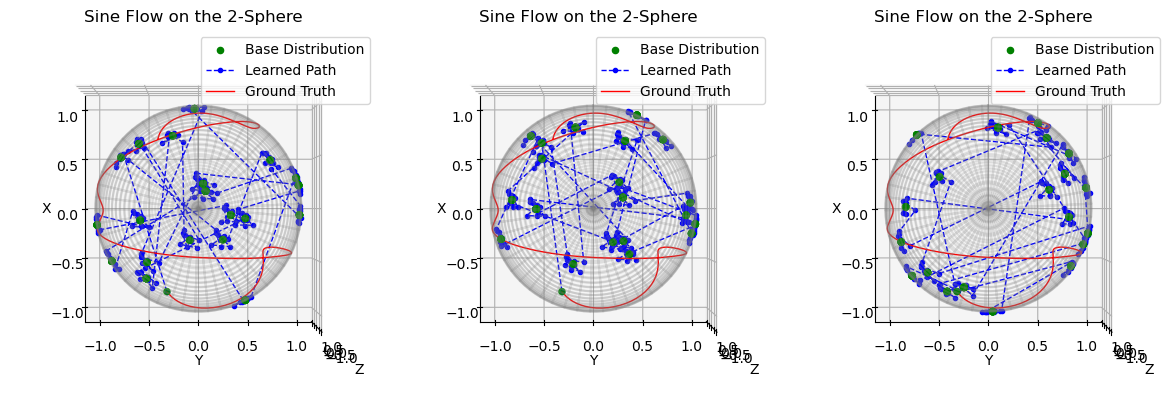

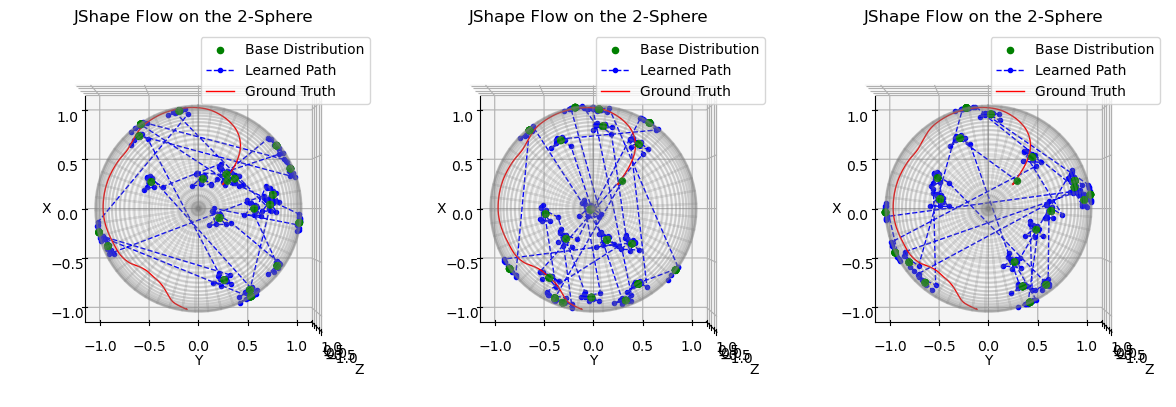

| iter   5000 | 16.98 ms/step | train loss    0.082 
| iter   5000 | validation loss:    0.091 
| iter  10000 | 16.93 ms/step | train loss    0.052 
| iter  10000 | validation loss:    0.045 


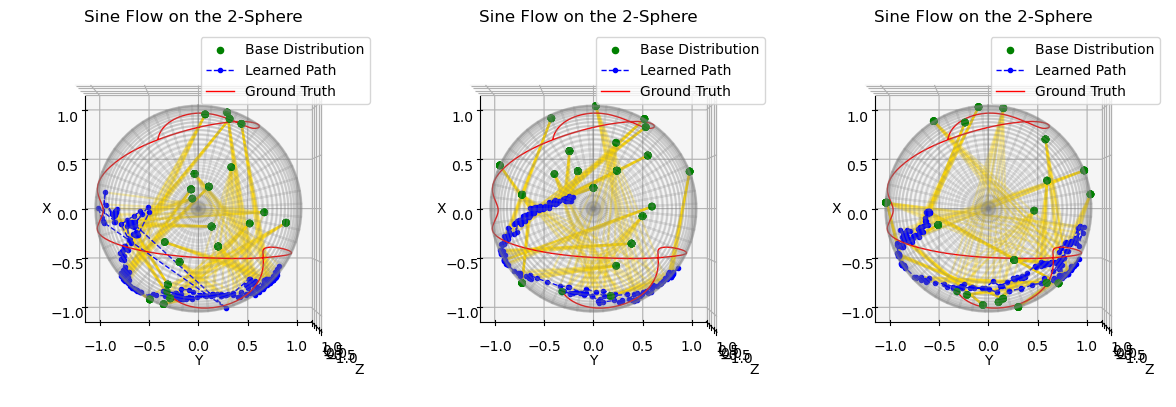

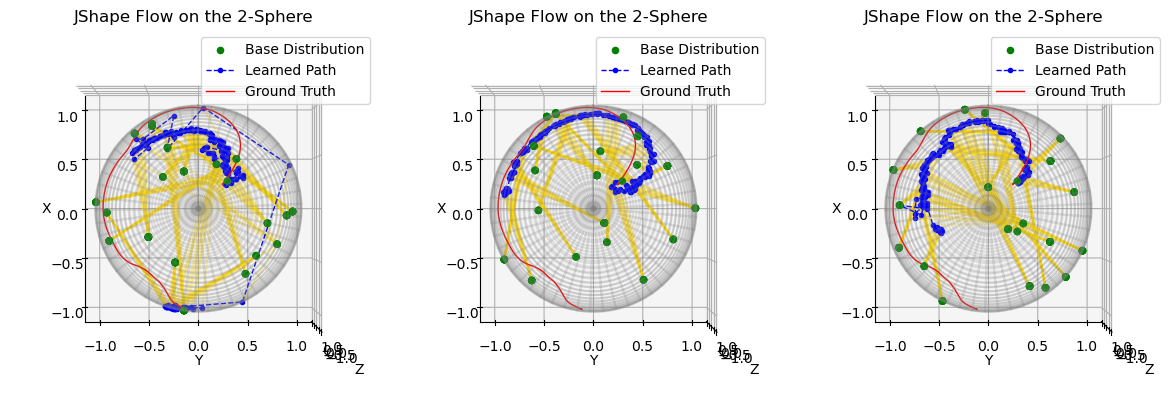

KeyboardInterrupt: 

In [ ]:
device = run_parameters['train']['device']
vf.to(device)

optim = torch.optim.Adam(vf.parameters(), lr=run_parameters['train']['lr'])
scheduler = torch.optim.lr_scheduler.StepLR(optim, 
                                            step_size=run_parameters['scheduler']['step'], 
                                            gamma=run_parameters['scheduler']['gamma'])

path = GeodesicProbPath(scheduler=CondOTScheduler(), manifold=manifold)

start_time = time.time()
for i in range(run_parameters['train']['epochs']):
  for batch in train_dataloader:
    optim.zero_grad()

    train_loss = step(vf=vf, 
                      batch=batch, 
                      run_parameters=run_parameters, 
                      manifold=manifold, 
                      path=path, 
                      device=device)
    
    train_loss.backward()
    optim.step()
    scheduler.step()

    if i > run_parameters['ema']['warmup'] and i % run_parameters['ema']['update'] == 0: 
      ema_vf.update()

    if i % run_parameters['train']['print_every'] == 0:
      elapsed = time.time() - start_time
      print('| iter {:6d} | {:5.2f} sec | train loss {:8.3f} '
            .format(i, elapsed/1000, train_loss.item()))
      
      with torch.no_grad():
        ema_vf.store()
        ema_vf.copy_to()
        loss_val = step(vf=vf, 
                        batch=next(iter(val_dataloader)), 
                        run_parameters=run_parameters, 
                        manifold=manifold, 
                        path=path, 
                        device=device)
        ema_vf.restore()
        print('| iter {:6d} | validation loss: {:8.3f} '.format(i, loss_val))
      start_time = time.time()

    if i % run_parameters['train']['inf_every'] == 0:
        with torch.no_grad():
            ema_vf.store()
            ema_vf.copy_to()
            infered = run_inference(manifold=manifold,
                                    model=vf,
                                    run_parameters=run_parameters,
                                    class_labels=dataset.get_label_maping(),
                                    gt_obs=gt_obs)
            for label_name in infered.keys():
              plot_flow_on_sphere(infered[label_name]['results'], 
                                  infered[label_name]['samples'], 
                                  gt_obs[dataset.get_label_maping()[label_name]],
                                  label=label_name)
            ema_vf.restore()


In [13]:
torch.save(vf.state_dict(), os.path.join("./ckpt", 'vf_dual_good_200k_scale_factor_'+str(run_parameters['data']['scale_factor'])+'_.pth'))

In [ ]:
# vf.load_state_dict(torch.load(os.path.join("./ckpt", 'vf_dual_good_200k_scale_factor_'+str(run_parameters['data']['scale_factor'])+'_.pth'), weights_only=True))
# vf.eval()

StateMLP(
  (label_embedding): Embedding(2, 24)
  (model): SequentialDiffEq(
    (layers): ModuleList(
      (0): ConcatLinear_v2(
        (_layer): Linear(in_features=91, out_features=96, bias=True)
        (_hyper_bias): Linear(in_features=1, out_features=96, bias=False)
      )
      (1): TimeDependentSwish(
        (beta): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): Softplus(beta=1.0, threshold=20.0)
          (2): Linear(in_features=64, out_features=96, bias=True)
          (3): Softplus(beta=1.0, threshold=20.0)
        )
      )
      (2): ConcatLinear_v2(
        (_layer): Linear(in_features=96, out_features=96, bias=True)
        (_hyper_bias): Linear(in_features=1, out_features=96, bias=False)
      )
      (3): TimeDependentSwish(
        (beta): Sequential(
          (0): Linear(in_features=1, out_features=64, bias=True)
          (1): Softplus(beta=1.0, threshold=20.0)
          (2): Linear(in_features=64, out_features=96, bi

In [8]:
criterion =  SoftDTW(gamma=1.0, normalize=True)

In [42]:
class_labels = dataset.get_label_maping()
for label_name in list(class_labels.keys()):
    results = []
    samples = []
    errors = []
    for _ in range(run_parameters['train']['inf_runs_num']):
        label = torch.tensor(class_labels[label_name],dtype=torch.long).unsqueeze(0)
        res, samp, paths = infer_model(model=vf, 
                        start=gt_obs[class_labels[label_name],0,:run_parameters['data']['dim']], 
                        manifold=manifold,
                        label=label,
                        dim_manifold=run_parameters['data']['dim'],
                        model_horizon=run_parameters['data']['horizon_size'],
                        inference_horizon=run_parameters['data']['inference_horizon'],
                        sample_points=run_parameters['data']['sample_points'],
                        mean=run_parameters['data']['mean'],
                        std=run_parameters['data']['std'],
                        step_size=0.33333,
                        return_intermediates=True)
        results.append(res)
        samples.append(samp)
        for sample in tqdm(range(len(paths)), desc="Path error", leave=False):
            path = paths[sample]
            for i in range(path.shape[2]):
                real_geodesic = sample_uniform_geodesic_path(manifold=manifold, 
                                                            start=path[0,0,i,:], #[1/step, b, horizon, dim]
                                                            finish=path[-1,0,i,:],
                                                            num_points=path.shape[0])
                errors.append(curve_geodesic_MSE(manifold=manifold, 
                                                x_curve=real_geodesic, 
                                                y_curve=path[:,0,i,:]))
        
    plot_flow_on_sphere(results, samples, gt_obs[class_labels[label_name]],label=label_name,dynamic =True)
    print(np.array(errors).mean())

Output()

0.00039446421518247587


In [ ]:
def plot_points(points, 
                title="3D Scatter Plot", 
                color="blue", 
                s=20, 
                show_grid=True,
                elev=0,
                azim=0):
    if isinstance(points, torch.Tensor):
        points = points.cpu().numpy()

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

   # print(points.shape)

    ax.scatter(points[:, 0], points[:, 1], points[:, 2], color=color, s=s)

    # Labels and title
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title(title)

    # Optional grid
    ax.grid(show_grid)

    # Set equal aspect ratio
    max_range = (points.max() - points.min()) / 2
    mid = points.mean(axis=0)
    # ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    # ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    # ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 50)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))
    ax.plot_wireframe(x, y, z, color="gray", alpha=0.2)

    # Adjust view to center the north pole
    ax.view_init(elev=elev, azim=azim)

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("Flow on the 2-Sphere")
    
    plt.tight_layout()
    # Interactive rotation
    plt.show()

In [12]:
results_euc = torch.load('euclidean_inference.pt', weights_only=True)
samples_euc = torch.load('euclidean_samples.pt', weights_only=True)

In [13]:
results_euc_proj = wrap(manifold=manifold, samples=results_euc[0])
samples_euc_proj = wrap(manifold=manifold, samples=samples_euc[0])

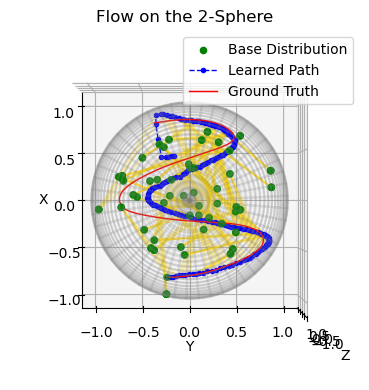

In [14]:
plot_flow_on_sphere(results_list=[results_euc_proj], samples_list=[samples_euc_proj], gt_samples=gt_obs)

In [15]:
print(criterion(results_euc_proj[:50], gt_obs[1:50,:3]))

tensor(0.6719)
